In [1]:
pip install trimesh

     |████████████████████████████████| 640 kB 6.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import random
import glob
import trimesh
import numpy as np
import tensorflow as tf


from matplotlib import pyplot as plt
import scipy 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv3D, Dense ,Dropout, Flatten, Activation, MaxPooling3D, Input
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM


from sklearn.model_selection import train_test_split, KFold,StratifiedKFold

from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import pathlib


2022-01-05 16:39:07.300697: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')

    print("reading from cloud...")
    path = "/content/drive/MyDrive/Colab Notebooks/MPPE/data_70p_overhang/stls_opt/"
    path_vox = "/content/drive/MyDrive/Colab Notebooks/MPPE/data_70p_overhang/voxelsFloat/"
     
    path = "/content/drive/MyDrive/data_70p_overhang/stls_opt/"
    path_vox = "/content/drive/MyDrive/data_70p_overhang/voxelsFloat/"
    path_split = "/content/drive/MyDrive/data_70p_overhang/12/"

except:
    import pathlib
    print("reading from disk")
    path = str(pathlib.Path().resolve())+"/dataset/stls_opt/"
    path_vox = str(pathlib.Path().resolve())+"/dataset/voxels/"
    path_split = str(pathlib.Path().resolve())+"/dataset/42/"


mesh = trimesh.load(path+"63_8475_10313_17790_28845.stl")

reading from disk


In [3]:
def calculate_cost(filename):
  #params
  #time - parts usally need 15 minutes for preparation
  #1h - 10eur
  price_per_h = 2
  price_per_meter = 0.17#0.1133 #150 meters costs 17e 
  filament_diameter = 2.85 #mm
  filament_phi = np.power(filament_diameter/2,2)*np.pi #mm^2
  
  support_removal_multiplier= 2
  support_removal_multiplier_time = 1.5
  profit_margin = 0.1
  #larger parts need longer time + 5 minutes slice time. 
  
  #get data from filename
  data = filename.replace(".","_").split("_")
  data = [int(x) for x in data[:-1]]

  #calculate cost from filament lenght

  #calulate cost no support 
  cost_filament = ((data[2]/(filament_phi*1000)))*price_per_meter

  #calulcate cost of printing supports only 
  cost_supports = (abs(data[2]-data[4])/(filament_phi*1000))*price_per_meter
  cost_supports_removal = support_removal_multiplier*cost_supports

  #calulate timewise cost in hours
  print_time = data[1]
  print_time_supports = data[3]

  #convert to horus and include time for removing supports 
  print_time= (((print_time + 2*abs(print_time-print_time_supports))*support_removal_multiplier_time)/3600)
  print_time_cost = print_time * price_per_h

  #cena
  cost = (cost_filament+cost_supports+cost_supports_removal+print_time_cost)
  cost = (cost*profit_margin)+cost

  return cost

#cost = calculate_cost("89_88123_134991_106833_152824.stl")
#cost = calculate_cost("62_1605_2129_2398_3618.stl")
cost = calculate_cost("108_31956_48635_34435_50936.stl")
print(cost)

35.46582523917991


In [4]:
X = np.zeros([0,100,100,100])
X_volume = np.zeros([0,1])
X_area = np.zeros([0,1])

y = np.zeros(0)
count = 0
for filename in os.listdir(path_vox):
    if filename.endswith(".npy"):
        count = count +1
        #print("appending", filename.split(".")[0])
        img = np.load(path_vox+filename)

        img =(img -(np.min(img)))
        img = img/np.max(img)
        cost = calculate_cost(filename)
        
        img = np.swapaxes(img,0,-1)

        X = np.append(X,img[np.newaxis,...],axis=0)
        y = np.append(y,cost)
        
        mesh = trimesh.load(path+filename.split(".")[0]+".stl")
        
        mv = np.array(abs(mesh.volume))
        X_volume = np.append(X_volume,mv[np.newaxis,...])

        ma = np.array(abs(mesh.area))
        X_area = np.append(X_area,ma[np.newaxis,...])

print(count)
X_area = X_area[...,np.newaxis]
X_volume = X_volume[...,np.newaxis]
X = X[...,np.newaxis]

188


In [30]:
n_samples = X.shape[0]
train_ind, test_ind  = train_test_split(range(n_samples), test_size=0.2, random_state=36)

X_train = X[train_ind]
X_train_volume = X_volume[train_ind]
X_train_area = X_area[train_ind]
y_train = y[train_ind]

X_test = X[test_ind]
X_test_volume = X_volume[test_ind]
X_test_area = X_area[test_ind]
y_test = y[test_ind]

print("train",X_train.shape,X_train_volume.shape,X_train_area.shape)
print("test",X_test.shape,X_test_volume.shape,X_test_area.shape)

train (150, 100, 100, 100, 1) (150, 1) (150, 1)
test (38, 100, 100, 100, 1) (38, 1) (38, 1)


In [7]:
def augment(img,angle):

  img = scipy.ndimage.rotate(img,angle,axes=(0,1),order=3)
  n = 100
  desiredshape = np.array([n,n,n])
  zoomArray = desiredshape.astype(np.float32) / img.shape
  img = scipy.ndimage.interpolation.zoom(img, zoomArray).astype(np.float32)
  
  img =(img -(np.min(img)))

  img = img/np.max(img)
  return img

In [8]:
X_train_2 = np.zeros([0,100,100,100])
X_train_volume_2 = np.zeros([0,1])
X_train_area_2 = np.zeros([0,1])
y_train_2 = np.zeros(0)

for i,img in enumerate(X_train):
  for angle in range(0,330,30):
    img_aug = augment(img[:,:,:,0],angle)

    X_train_2 = np.append(X_train_2,img_aug[np.newaxis,...],axis=0)
    X_train_volume_2 = np.append(X_train_volume_2,X_train_volume[i])
    X_train_area_2 = np.append(X_train_area_2,X_train_area[i])

    y_train_2 = np.append(y_train_2,y_train[i])
  
X_train_area_2 = X_train_area_2[...,np.newaxis]
X_train_volume_2 = X_train_volume_2[...,np.newaxis]
X_train_2 = X_train_2[...,np.newaxis]

KeyboardInterrupt: 

In [ ]:
y_train.shape

(150,)

In [4]:
X_train = np.load(path_split+"/X_train.npy")
X_train_volume = np.load(path_split+"/X_train_volume.npy")
X_train_area = np.load(path_split+"/X_train_area.npy")
y_train = np.load(path_split+"/y_train.npy")

X_test = np.load(path_split+"/X_test.npy")
X_test_volume = np.load(path_split+"/X_test_volume.npy")
X_test_area = np.load(path_split+"/X_test_area.npy")
y_test = np.load(path_split+"/y_test.npy")

In [9]:
X_train_volume = X_trian_volume

In [31]:
#my net
input1 = keras.Input(shape=(X_train.shape[1:]))
input2 = keras.Input(shape=(X_train_volume.shape[1:]))
input3 = keras.Input(shape=(X_train_area.shape[1:]))

#y = Dense(1)(input2)
activ = "LeakyReLU"
# x = Conv3D(64,(7,7,7),strides = (2,2,2), activation=activ, padding = 'same')(input1)
# x = Conv3D(64,(7,7,7),strides = (2,2,2), activation=activ, padding = 'same')(x)
# x = MaxPooling3D(pool_size=(2, 2, 2))(x)
# x = layers.Dropout(0.3)(x)
n=3
x = Conv3D(32,(n,n,n),strides = (2,2,2), activation=activ, padding = 'same')(input1)
x = Conv3D(32,(n,n,n),strides = (2,2,2), activation=activ, padding = 'same')(x)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = layers.Dropout(0.3)(x)

x = Conv3D(16,(n,n,n), activation=activ, padding = 'same')(x)
x = Conv3D(16,(n,n,n),strides = (2,2,2), activation=activ, padding = 'same')(x)
x = MaxPooling3D(pool_size=(1, 1, 1))(x)
x = layers.Dropout(0.3)(x)

x = Conv3D(8,(n,n,n),strides = (2,2,2), activation=activ, padding = 'same')(x)
x = Conv3D(8,(n,n,n),strides = (2,2,2), activation=activ, padding = 'same')(x)
x = MaxPooling3D(pool_size=(1, 1, 1))(x)

x = Activation('relu')(x)

x = layers.Dropout(0.3)(x)

x = Flatten()(x)

x = layers.Concatenate(axis=1)([x,input2])
#x = Dense(4, activation = 'relu')(x)
x = layers.Concatenate(axis=1)([x,input3])

dense = Dense(2000, activation = activ)(x)
dense = Dense(300, activation = activ)(dense)
dense = Dense(150, activation = activ)(dense)
dense = Dense(20, activation = activ)(dense)
dense = Dense(16, activation = activ)(dense)
    # final layer with 10 neurons to classify the instances
output = Dense(1, activation = 'linear')(dense)
    
#outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=[input1,input2,input3], outputs=output, name="jjnet")

In [5]:
input1 = keras.Input(shape=(X_train.shape[1:]))
input2 = keras.Input(shape=(X_train_volume.shape[1:]))
input3 = keras.Input(shape=(X_train_area.shape[1:]))

activ = "relu"

# x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input1)
# x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
# x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(input1)
x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = TimeDistributed(Convolution2D(4, (3, 3), activation='relu', padding='same'))(x)
x = TimeDistributed(Convolution2D(4, (3, 3), activation='relu', padding='same'))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = Dropout(0.30)(x)

x = TimeDistributed(Convolution2D(4, (3, 3), activation='relu', padding='same'))(x)
x = TimeDistributed(Convolution2D(4, (3, 3), activation='relu', padding='same'))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = Dropout(0.30)(x)
x = TimeDistributed(Flatten())(x)
x = LSTM(8, return_sequences=True, unroll=False, dropout=0.3)(x)  # dropout=0.6
x = LSTM(8, return_sequences=False, unroll=False, dropout=0.3)(x)


x = layers.Concatenate(axis=1)([x,input2])

#x = Dense(4, activation = 'relu')(x)
x = layers.Concatenate(axis=1)([x,input3])

dense = Dense(2000, activation = activ)(x)
dense = Dense(300, activation = activ)(dense)
dense = Dense(150, activation = activ)(dense)
dense = Dense(20, activation = activ)(dense)
dense = Dense(16, activation = activ)(dense)
    # final layer with 10 neurons to classify the instances
output = Dense(1, activation = 'linear')(dense)
    

model = keras.Model(inputs=[input1,input2,input3], outputs=output, name="jjlstmnet")


2022-01-04 15:49:04.736439: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-01-04 15:49:04.791234: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-01-04 15:49:04.791282: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-01-04 15:49:04.794915: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-01-04 15:49:04.794999: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-01-04 15:49:04.796733: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [ ]:
#@title Default title text
#paper net 
input1 = keras.Input(shape=(X_train.shape[1:]))
input2 = keras.Input(shape=(X_train_volume.shape[1:]))
input3 = keras.Input(shape=(X_train_area.shape[1:]))



x = Conv3D(16,(3,3,3), activation='LeakyReLU', padding = 'same')(input1)
x = Conv3D(16,(3,3,3), activation='LeakyReLU', padding = 'same')(x)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = layers.Dropout(0.3)(x)

x = Conv3D(32,(3,3,3), activation='LeakyReLU', padding = 'same')(x)
x = Conv3D(32,(3,3,3), activation='LeakyReLU', padding = 'same')(x)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = layers.Dropout(0.3)(x)

x = Conv3D(8,(3,3,3), activation='LeakyReLU', padding = 'same')(x)

x = layers.Dropout(0.8)(x)

x = Flatten()(x)

x = layers.Concatenate(axis=1)([x,input2])
x = Dense(8, activation = 'LeakyReLU')(x)
dense = Dense(2000, activation = 'LeakyReLU')(x)
dense = Dense(300, activation = 'LeakyReLU')(dense)
dense = Dense(150, activation = 'LeakyReLU')(dense)
dense = Dense(20, activation = 'LeakyReLU')(dense)
dense = Dense(16, activation = 'LeakyReLU')(dense)
    # final layer with 10 neurons to classify the instances
output = Dense(1, activation = 'linear')(dense)
    
#outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=[input1,input2], outputs=output, name="papernet")

In [ ]:
def min_max(val):
  val =(val -(np.min(val)))
  val = val/np.max(val)


In [49]:
model.compile(
    loss="MAE",
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    metrics=["MAPE"],
)

model.fit([X_train,np.log(X_train_volume), np.log(X_train_area)], np.log(y_train), batch_size = 8, epochs = 200, verbose = 1)
#model.fit([X_train,X_train_volume, X_train_area], np.log(y_train),validation_split = 0.2, batch_size = 8, epochs = 100, verbose = 1)
#model.evaluate([X_test, np.log(X_test_volume),np.log(X_test_area)],y_test)

Epoch 1/200
19/19 [==============================] - 1s 30ms/step - loss: 0.0719 - MAPE: 11.6998
Epoch 2/200
19/19 [==============================] - 1s 31ms/step - loss: 0.0668 - MAPE: 5.8661
Epoch 3/200
19/19 [==============================] - 1s 32ms/step - loss: 0.0640 - MAPE: 6.2092
Epoch 4/200
19/19 [==============================] - 1s 33ms/step - loss: 0.0684 - MAPE: 6.1603
Epoch 5/200
19/19 [==============================] - 1s 32ms/step - loss: 0.0751 - MAPE: 8.2276
Epoch 6/200
19/19 [==============================] - 1s 33ms/step - loss: 0.0735 - MAPE: 11.5637
Epoch 7/200
19/19 [==============================] - 1s 32ms/step - loss: 0.0708 - MAPE: 7.6593
Epoch 8/200
19/19 [==============================] - 1s 33ms/step - loss: 0.0675 - MAPE: 5.8584
Epoch 9/200
19/19 [==============================] - 1s 33ms/step - loss: 0.0679 - MAPE: 6.4529
Epoch 10/200
19/19 [==============================] - 1s 32ms/step - loss: 0.0712 - MAPE: 10.3728
Epoch 11/200
19/19 [================

19/19 [==============================] - 1s 31ms/step - loss: 0.0650 - MAPE: 8.5227
Epoch 86/200
19/19 [==============================] - 1s 33ms/step - loss: 0.0607 - MAPE: 5.2289
Epoch 87/200
19/19 [==============================] - 1s 33ms/step - loss: 0.0561 - MAPE: 5.2367
Epoch 88/200
19/19 [==============================] - 1s 32ms/step - loss: 0.0641 - MAPE: 4.9756
Epoch 89/200
19/19 [==============================] - 1s 32ms/step - loss: 0.0692 - MAPE: 4.7634
Epoch 90/200
19/19 [==============================] - 1s 32ms/step - loss: 0.0682 - MAPE: 9.7296
Epoch 91/200
19/19 [==============================] - 1s 32ms/step - loss: 0.0644 - MAPE: 6.6447
Epoch 92/200
19/19 [==============================] - 1s 32ms/step - loss: 0.0667 - MAPE: 6.4576
Epoch 93/200
19/19 [==============================] - 1s 33ms/step - loss: 0.0706 - MAPE: 7.7149
Epoch 94/200
19/19 [==============================] - 1s 31ms/step - loss: 0.0697 - MAPE: 10.8988
Epoch 95/200
19/19 [======================

In [25]:
model.evaluate([X_test, np.log(X_test_volume),np.log(X_test_area)],y_test)

2022-01-03 21:38:03.739277: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 518.17MiB (rounded to 543338496)requested by op jjnet/conv3d_7/Conv3D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-01-03 21:38:03.739465: I tensorflow/core/common_runtime/bfc_allocator.cc:1000] BFCAllocator dump for GPU_0_bfc
2022-01-03 21:38:03.739485: I tensorflow/core/common_runtime/bfc_allocator.cc:1007] Bin (256): 	Total Chunks: 147, Chunks in use: 147. 36.8KiB allocated for chunks. 36.8KiB in use in bin. 4.8KiB client-requested in use in bin.
2022-01-03 21:38:03.739493: I tensorflow/core/common_runtime/bfc_allocator.cc:1007] Bin (512): 	Total Chunks: 6, Chunks in use: 6. 4.5KiB allocated for chunks. 4.5KiB in use in bin. 3.5KiB client-requested in use in bin.
2022-01-03 21:38:0

ResourceExhaustedError:  OOM when allocating tensor with shape[32,32,51,51,51] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node jjnet/conv3d_7/Conv3D (defined at tmp/ipykernel_49319/1886996265.py:7) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_test_function_25072]

Function call stack:
test_function


In [50]:
preds = model.predict([X_test, np.log(X_test_volume),np.log(X_test_area)])#*y_train_max
#preds = model.predict([X_test,X_test_volume,X_test_area])#*y_train_max

In [24]:
#mae
print(np.sum(abs(np.exp(preds)-(y_test)))/len(preds),np.sum(abs(((preds)-(np.log(y_test)))))/len(preds))

1704.2304685959189 63.12668178023365


In [38]:
#MAPE
np.sum(abs((np.exp(preds)-(y_test))/(y_test)))/len(preds)

341.2339792734442

In [51]:
mae = 0
mape = 0
rmse = 0
c = 0
for e,i in zip(np.exp(preds),y_test):
  mae = mae + abs(e-i)
  mape = mape + abs((e-i)/i)
  rmse = rmse + np.power((i-e),2)
  c = c +1 
  print("Predikcija",round(e[0],2)," Cena ",round(i,2))
print("MAE",mae/c)
print("MAPE",mape/c)
print("RMSE",np.sqrt(rmse/c))

Predikcija 3.18  Cena  2.6
Predikcija 41.08  Cena  38.24
Predikcija 7.2  Cena  5.34
Predikcija 11.6  Cena  9.56
Predikcija 68.64  Cena  90.1
Predikcija 19.8  Cena  11.34
Predikcija 9.83  Cena  8.12
Predikcija 2.08  Cena  1.99
Predikcija 15.96  Cena  14.89
Predikcija 13.4  Cena  8.58
Predikcija 18.1  Cena  16.09
Predikcija 43.98  Cena  36.27
Predikcija 4.4  Cena  1.76
Predikcija 14.43  Cena  6.81
Predikcija 15.02  Cena  9.04
Predikcija 11.17  Cena  10.26
Predikcija 68.8  Cena  126.5
Predikcija 73.0  Cena  66.36
Predikcija 13.89  Cena  14.33
Predikcija 46.43  Cena  38.22
Predikcija 12.13  Cena  10.48
Predikcija 109.97  Cena  171.18
Predikcija 5.83  Cena  4.62
Predikcija 0.47  Cena  0.42
Predikcija 7.08  Cena  8.82
Predikcija 0.48  Cena  0.4
Predikcija 132.02  Cena  132.82
Predikcija 6.49  Cena  4.49
Predikcija 1.04  Cena  0.9
Predikcija 1.46  Cena  0.95
Predikcija 17.76  Cena  23.98
Predikcija 272.0  Cena  252.68
Predikcija 23.11  Cena  18.86
Predikcija 16.97  Cena  15.76
Predikcija 10.7

In [52]:
for e,i in zip(np.exp(preds),y_test):
  print(round(e[0],2),",",round(i,2))

print(mae/c)
print(mape/c)
print(np.sqrt(rmse/c))

3.18 , 2.6
41.08 , 38.24
7.2 , 5.34
11.6 , 9.56
68.64 , 90.1
19.8 , 11.34
9.83 , 8.12
2.08 , 1.99
15.96 , 14.89
13.4 , 8.58
18.1 , 16.09
43.98 , 36.27
4.4 , 1.76
14.43 , 6.81
15.02 , 9.04
11.17 , 10.26
68.8 , 126.5
73.0 , 66.36
13.89 , 14.33
46.43 , 38.22
12.13 , 10.48
109.97 , 171.18
5.83 , 4.62
0.47 , 0.42
7.08 , 8.82
0.48 , 0.4
132.02 , 132.82
6.49 , 4.49
1.04 , 0.9
1.46 , 0.95
17.76 , 23.98
272.0 , 252.68
23.11 , 18.86
16.97 , 15.76
10.74 , 9.47
2.49 , 1.45
113.5 , 117.49
16.16 , 10.82
[6.75877]
[0.307868]
[14.885205]


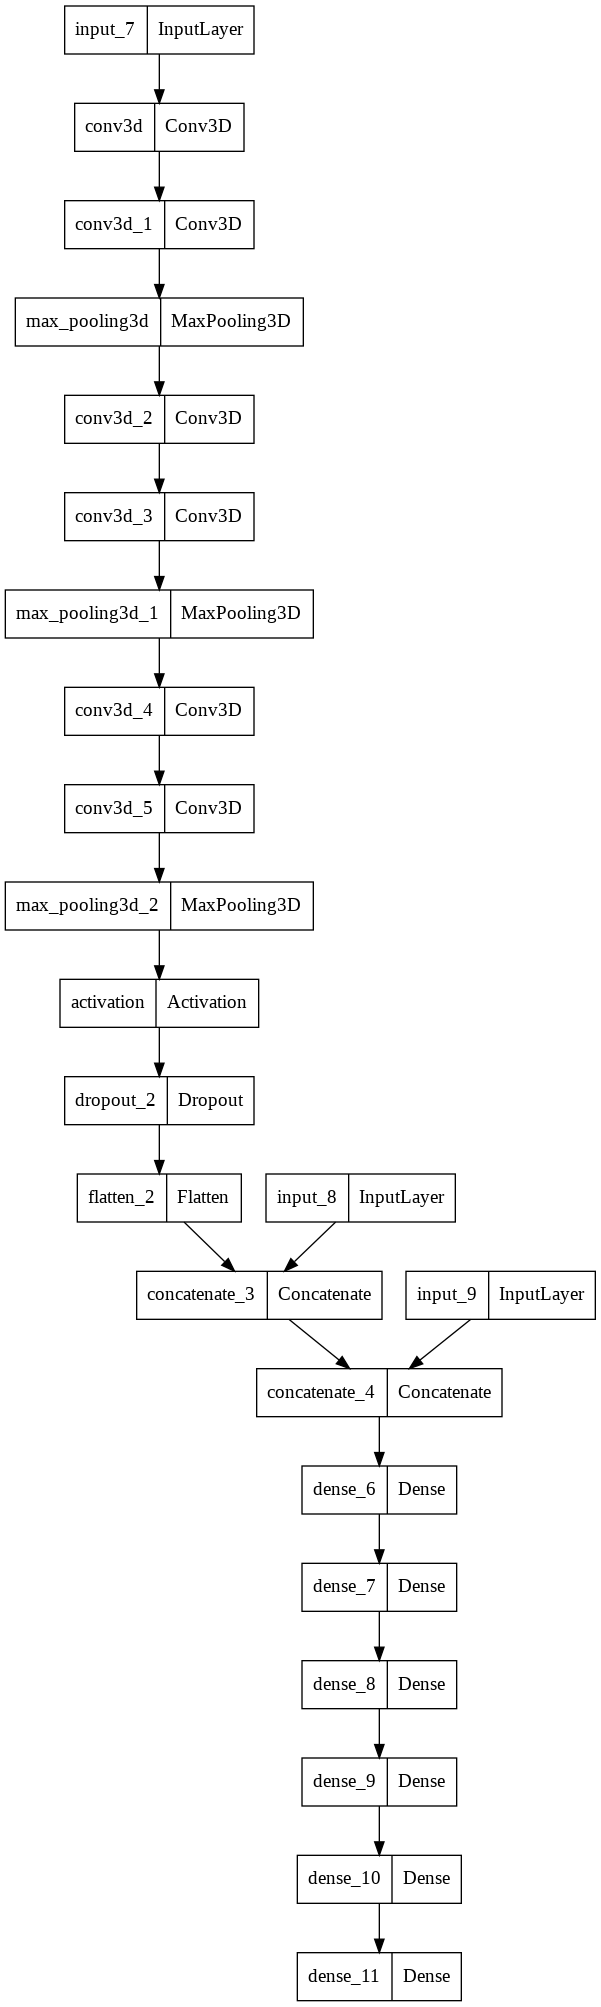

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False)

In [5]:
#vox 
epochs_per_round = 150
seeds = [12,36,42]
#seeds = [42]
rounds_lr = [0.0001,0.00008,0.00004,0.00002]

for seed in seeds:

    print("______________________________________________")


    n_samples = X.shape[0]
    train_ind, test_ind  = train_test_split(range(n_samples), test_size=0.2, random_state=seed)

    X_train = X[train_ind]
    X_train_volume = X_volume[train_ind]
    X_train_area = X_area[train_ind]
    y_train = y[train_ind]

    X_test = X[test_ind]
    X_test_volume = X_volume[test_ind]
    X_test_area = X_area[test_ind]
    y_test = y[test_ind]

    print("train",X_train.shape,X_train_volume.shape,X_train_area.shape)
    print("test",X_test.shape,X_test_volume.shape,X_test_area.shape)

    #my net
    input1 = keras.Input(shape=(X_train.shape[1:]))
    input2 = keras.Input(shape=(X_train_volume.shape[1:]))
    input3 = keras.Input(shape=(X_train_area.shape[1:]))

    #y = Dense(1)(input2)
    activ = "LeakyReLU"
    # x = Conv3D(64,(7,7,7),strides = (2,2,2), activation=activ, padding = 'same')(input1)
    # x = Conv3D(64,(7,7,7),strides = (2,2,2), activation=activ, padding = 'same')(x)
    # x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    # x = layers.Dropout(0.3)(x)
    n=3
    x = Conv3D(32,(n,n,n),strides = (2,2,2), activation=activ, padding = 'same')(input1)
    x = Conv3D(32,(n,n,n),strides = (2,2,2), activation=activ, padding = 'same')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = Conv3D(16,(n,n,n), activation=activ, padding = 'same')(x)
    x = Conv3D(16,(n,n,n),strides = (2,2,2), activation=activ, padding = 'same')(x)
    x = MaxPooling3D(pool_size=(1, 1, 1))(x)
    x = layers.Dropout(0.3)(x)

    x = Conv3D(8,(n,n,n),strides = (2,2,2), activation=activ, padding = 'same')(x)
    x = Conv3D(8,(n,n,n),strides = (2,2,2), activation=activ, padding = 'same')(x)
    x = MaxPooling3D(pool_size=(1, 1, 1))(x)

    x = Activation('relu')(x)

    x = layers.Dropout(0.3)(x)

    x = Flatten()(x)

    x = layers.Concatenate(axis=1)([x,input2])
    #x = Dense(4, activation = 'relu')(x)
    x = layers.Concatenate(axis=1)([x,input3])

    dense = Dense(2000, activation = activ)(x)
    dense = Dense(300, activation = activ)(dense)
    dense = Dense(150, activation = activ)(dense)
    dense = Dense(20, activation = activ)(dense)
    dense = Dense(16, activation = activ)(dense)
        # final layer with 10 neurons to classify the instances
    output = Dense(1, activation = 'linear')(dense)

    #outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=[input1,input2,input3], outputs=output, name="jjnet")

    for round_lr in rounds_lr:
        
        print(" ")
        print("starting round lr",round_lr," and seed",seed)

        model.compile(
            loss="MAE",
            optimizer=keras.optimizers.Adam(learning_rate=round_lr),
            metrics=["MAPE"],
        )



        model.fit([X_train,np.log(X_train_volume), np.log(X_train_area)], np.log(y_train), batch_size = 8, epochs = epochs_per_round, verbose = 0)
        #model.fit([X_train,X_train_volume, X_train_area], np.log(y_train),validation_split = 0.2, batch_size = 8, epochs = 100, verbose = 1)
        #model.evaluate([X_test, np.log(X_test_volume),np.log(X_test_area)],y_test)

        preds = model.predict([X_test, np.log(X_test_volume),np.log(X_test_area)])#*y_train_max
        #preds = model.predict([X_test,X_test_volume,X_test_area])#*y_train_max

        mae = 0
        mape = 0
        rmse = 0
        c = 0
        for e,i in zip(np.exp(preds),y_test):
          mae = mae + abs(e-i)
          mape = mape + abs((e-i)/i)
          rmse = rmse + np.power((i-e),2)
          c = c +1 

        print("results for round:",round_lr," seed",seed)
        for e,i in zip(np.exp(preds),y_test):
          print(round(e[0],2),",",round(i,2))

        print(mae/c)
        print(mape/c)
        print(np.sqrt(rmse/c))
        print(" ")
        print("next round!")


______________________________________________
train (150, 100, 100, 100, 1) (150, 1) (150, 1)
test (38, 100, 100, 100, 1) (38, 1) (38, 1)


2022-01-05 16:39:59.847627: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-01-05 16:39:59.898192: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-01-05 16:39:59.898234: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-01-05 16:39:59.913461: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-01-05 16:39:59.913536: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-01-05 16:39:59.920204: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

 
starting round lr 0.0001  and seed 12


2022-01-05 16:40:01.437732: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-05 16:40:01.456559: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz
2022-01-05 16:40:02.068819: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-01-05 16:40:02.781367: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-01-05 16:40:03.635594: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-01-05 16:40:04.416894: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


results for round: 0.0001  seed 12
57.01 , 35.47
12.72 , 9.5
75.63 , 51.93
41.47 , 62.18
82.85 , 69.82
45.06 , 61.51
8.88 , 5.75
52.15 , 29.22
8.63 , 5.79
18.52 , 7.76
13.86 , 13.95
10.61 , 4.05
32.64 , 57.87
47.5 , 32.23
1.33 , 0.9
10.23 , 11.02
1.05 , 0.63
6.93 , 6.15
1.09 , 0.56
41.49 , 30.78
4.46 , 5.15
7.93 , 8.82
18.9 , 26.78
3.31 , 2.6
7.23 , 6.58
8.97 , 12.58
2.45 , 1.39
22.77 , 15.75
14.22 , 10.48
25.91 , 22.49
40.09 , 90.1
18.33 , 7.06
117.4 , 117.49
2.15 , 0.82
49.6 , 38.24
13.55 , 9.47
28.07 , 33.02
6.13 , 5.86
[8.21389]
[0.4778966]
[13.125989]
 
next round!
 
starting round lr 8e-05  and seed 12
results for round: 8e-05  seed 12
43.34 , 35.47
10.76 , 9.5
58.51 , 51.93
28.89 , 62.18
63.09 , 69.82
31.62 , 61.51
9.12 , 5.75
35.58 , 29.22
7.82 , 5.79
14.27 , 7.76
11.6 , 13.95
8.33 , 4.05
24.98 , 57.87
37.45 , 32.23
1.05 , 0.9
8.97 , 11.02
0.72 , 0.63
5.93 , 6.15
0.9 , 0.56
33.66 , 30.78
3.89 , 5.15
6.73 , 8.82
13.85 , 26.78
2.94 , 2.6
6.38 , 6.58
8.25 , 12.58
2.1 , 1.39
19.18 

results for round: 2e-05  seed 42
21.64 , 18.86
2.86 , 1.64
8.03 , 7.42
6.34 , 3.91
66.23 , 30.84
75.62 , 90.17
21.46 , 9.5
16.48 , 32.13
8.5 , 14.33
31.44 , 36.27
53.89 , 38.4
9.77 , 4.49
0.28 , 0.17
20.9 , 17.66
28.42 , 61.51
16.01 , 13.95
9.3 , 5.66
16.41 , 14.49
7.75 , 7.43
0.86 , 0.4
7.85 , 3.42
291.63 , 252.68
9.33 , 7.06
73.52 , 308.13
4.8 , 5.34
8.89 , 11.02
2.42 , 1.39
5.61 , 3.12
35.21 , 33.02
14.33 , 12.16
10.78 , 5.41
2.56 , 2.72
14.17 , 63.85
17.88 , 10.29
1.91 , 0.85
16.55 , 10.48
17.48 , 15.76
25.45 , 17.72
[13.974894]
[0.5226754]
[40.58042]
 
next round!


In [6]:
#lstm
epochs_per_round = 20
seeds = [12,36,42]
rounds_lr = [0.001,0.0008,0.0004,0.0002,0.0001]

for seed in seeds:
    print("______________________________________________")
    
    n_samples = X.shape[0]
    train_ind, test_ind  = train_test_split(range(n_samples), test_size=0.2, random_state=seed)

    X_train = X[train_ind]
    X_train_volume = X_volume[train_ind]
    X_train_area = X_area[train_ind]
    y_train = y[train_ind]

    X_test = X[test_ind]
    X_test_volume = X_volume[test_ind]
    X_test_area = X_area[test_ind]
    y_test = y[test_ind]

    print("train",X_train.shape,X_train_volume.shape,X_train_area.shape)
    print("test",X_test.shape,X_test_volume.shape,X_test_area.shape)

    input1 = keras.Input(shape=(X_train.shape[1:]))
    input2 = keras.Input(shape=(X_train_volume.shape[1:]))
    input3 = keras.Input(shape=(X_train_area.shape[1:]))

    activ = "relu"

    # x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input1)
    # x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    # x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(input1)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(4, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(4, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.30)(x)

    x = TimeDistributed(Convolution2D(4, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(4, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.30)(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(8, return_sequences=True, unroll=False, dropout=0.3)(x)  # dropout=0.6
    x = LSTM(8, return_sequences=False, unroll=False, dropout=0.3)(x)


    #x = layers.Concatenate(axis=1)([x,input2])

    #x = Dense(4, activation = 'relu')(x)
    x = layers.Concatenate(axis=1)([x,input3])

    dense = Dense(2000, activation = activ)(x)
    dense = Dense(300, activation = activ)(dense)
    dense = Dense(150, activation = activ)(dense)
    dense = Dense(20, activation = activ)(dense)
    dense = Dense(16, activation = activ)(dense)
        # final layer with 10 neurons to classify the instances
    output = Dense(1, activation = 'linear')(dense)


    model = keras.Model(inputs=[input1,input2,input3], outputs=output, name="jjlstmnet")

    for round_lr in rounds_lr:
        print(" ")
        print("starting round lr",round_lr," and seed",seed)

        model.compile(
            loss="MAE",
            optimizer=keras.optimizers.Adam(learning_rate=round_lr),
            metrics=["MAPE"],
        )
    
    

        model.fit([X_train,np.log(X_train_volume), np.log(X_train_area)], np.log(y_train), batch_size = 8, epochs = epochs_per_round, verbose = 0)
        #model.fit([X_train,X_train_volume, X_train_area], np.log(y_train),validation_split = 0.2, batch_size = 8, epochs = 100, verbose = 1)
        #model.evaluate([X_test, np.log(X_test_volume),np.log(X_test_area)],y_test)

        preds = model.predict([X_test, np.log(X_test_volume),np.log(X_test_area)])#*y_train_max
        #preds = model.predict([X_test,X_test_volume,X_test_area])#*y_train_max
        
        mae = 0
        mape = 0
        rmse = 0
        c = 0
        for e,i in zip(np.exp(preds),y_test):
          mae = mae + abs(e-i)
          mape = mape + abs((e-i)/i)
          rmse = rmse + np.power((i-e),2)
          c = c +1 
          
        print("results for round:",round_lr," seed",seed)
        for e,i in zip(np.exp(preds),y_test):
          print(round(e[0],2),",",round(i,2))

        print(mae/c)
        print(mape/c)
        print(np.sqrt(rmse/c))
        print(" ")
        print("next round!")

______________________________________________
train (150, 100, 100, 100, 1) (150, 1) (150, 1)
test (38, 100, 100, 100, 1) (38, 1) (38, 1)
 
starting round lr 0.001  and seed 12
results for round: 0.001  seed 12
34.3 , 35.47
6.65 , 9.5
43.27 , 51.93
22.81 , 62.18
44.58 , 69.82
26.86 , 61.51
4.33 , 5.75
17.37 , 29.22
4.09 , 5.79
5.96 , 7.76
11.35 , 13.95
4.8 , 4.05
38.58 , 57.87
21.37 , 32.23
0.75 , 0.9
12.43 , 11.02
0.51 , 0.63
5.02 , 6.15
0.43 , 0.56
30.48 , 30.78
3.03 , 5.15
5.35 , 8.82
8.16 , 26.78
2.1 , 2.6
6.19 , 6.58
15.23 , 12.58
1.69 , 1.39
10.29 , 15.75
14.69 , 10.48
18.01 , 22.49
61.85 , 90.1
5.76 , 7.06
134.23 , 117.49
0.39 , 0.82
30.28 , 38.24
8.41 , 9.47
19.85 , 33.02
5.91 , 5.86
[7.279944]
[0.26857635]
[12.437867]
 
next round!
 
starting round lr 0.0008  and seed 12
results for round: 0.0008  seed 12
48.23 , 35.47
9.88 , 9.5
63.42 , 51.93
29.31 , 62.18
63.89 , 69.82
38.41 , 61.51
5.6 , 5.75
21.71 , 29.22
4.84 , 5.79
7.27 , 7.76
14.6 , 13.95
5.68 , 4.05
51.86 , 57.87
28.7

results for round: 0.0002  seed 42
17.73 , 18.86
2.18 , 1.64
6.52 , 7.42
3.72 , 3.91
38.67 , 30.84
64.28 , 90.17
10.65 , 9.5
48.8 , 32.13
8.93 , 14.33
39.91 , 36.27
48.04 , 38.4
8.49 , 4.49
0.19 , 0.17
18.47 , 17.66
37.56 , 61.51
11.38 , 13.95
4.01 , 5.66
11.99 , 14.49
6.35 , 7.43
0.55 , 0.4
3.81 , 3.42
223.31 , 252.68
6.84 , 7.06
201.78 , 308.13
5.63 , 5.34
15.96 , 11.02
1.74 , 1.39
4.14 , 3.12
20.81 , 33.02
11.51 , 12.16
3.79 , 5.41
2.24 , 2.72
75.24 , 63.85
6.29 , 10.29
0.97 , 0.85
11.36 , 10.48
14.52 , 15.76
17.1 , 17.72
[7.522129]
[0.22634353]
[19.36763]
 
next round!
 
starting round lr 0.0001  and seed 42
results for round: 0.0001  seed 42
16.5 , 18.86
2.13 , 1.64
5.92 , 7.42
3.42 , 3.91
35.49 , 30.84
59.73 , 90.17
9.97 , 9.5
45.6 , 32.13
8.17 , 14.33
42.53 , 36.27
41.82 , 38.4
7.8 , 4.49
0.16 , 0.17
17.07 , 17.66
37.54 , 61.51
10.53 , 13.95
3.67 , 5.66
11.13 , 14.49
5.73 , 7.43
0.47 , 0.4
3.48 , 3.42
206.41 , 252.68
6.27 , 7.06
192.66 , 308.13
5.14 , 5.34
14.95 , 11.02
1.55 , 1

In [ ]:
#aug vox !!!

#vox 
epochs_per_round = 100
seeds = [12,36,42]
#seeds = [42]
rounds_lr = [0.0001,0.00008,0.00004,0.00002]

for seed in seeds:

    print("______________________________________________")
    
    path_split = str(pathlib.Path().resolve())+"/dataset/"+str(seed)

    X_train = np.load(path_split+"/X_train.npy")
    X_train_volume = np.load(path_split+"/X_train_volume.npy")
    X_train_area = np.load(path_split+"/X_train_area.npy")
    y_train = np.load(path_split+"/y_train.npy")

    X_test = np.load(path_split+"/X_test.npy")
    X_test_volume = np.load(path_split+"/X_test_volume.npy")
    X_test_area = np.load(path_split+"/X_test_area.npy")
    y_test = np.load(path_split+"/y_test.npy")

    
    print("train",X_train.shape,X_train_volume.shape,X_train_area.shape)
    print("test",X_test.shape,X_test_volume.shape,X_test_area.shape)

    #my net
    input1 = keras.Input(shape=(X_train.shape[1:]))
    input2 = keras.Input(shape=(X_train_volume.shape[1:]))
    input3 = keras.Input(shape=(X_train_area.shape[1:]))

    #y = Dense(1)(input2)
    activ = "LeakyReLU"
    # x = Conv3D(64,(7,7,7),strides = (2,2,2), activation=activ, padding = 'same')(input1)
    # x = Conv3D(64,(7,7,7),strides = (2,2,2), activation=activ, padding = 'same')(x)
    # x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    # x = layers.Dropout(0.3)(x)
    n=3
    x = Conv3D(32,(n,n,n),strides = (2,2,2), activation=activ, padding = 'same')(input1)
    x = Conv3D(32,(n,n,n),strides = (2,2,2), activation=activ, padding = 'same')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = Conv3D(16,(n,n,n), activation=activ, padding = 'same')(x)
    x = Conv3D(16,(n,n,n),strides = (2,2,2), activation=activ, padding = 'same')(x)
    x = MaxPooling3D(pool_size=(1, 1, 1))(x)
    x = layers.Dropout(0.3)(x)

    x = Conv3D(8,(n,n,n),strides = (2,2,2), activation=activ, padding = 'same')(x)
    x = Conv3D(8,(n,n,n),strides = (2,2,2), activation=activ, padding = 'same')(x)
    x = MaxPooling3D(pool_size=(1, 1, 1))(x)

    x = Activation('relu')(x)

    x = layers.Dropout(0.3)(x)

    x = Flatten()(x)

    x = layers.Concatenate(axis=1)([x,input2])
    x = Dense(4, activation = 'relu')(x)
    x = layers.Concatenate(axis=1)([x,input3])

    dense = Dense(2000, activation = activ)(x)
    dense = Dense(300, activation = activ)(dense)
    dense = Dense(150, activation = activ)(dense)
    dense = Dense(20, activation = activ)(dense)
    dense = Dense(16, activation = activ)(dense)
        # final layer with 10 neurons to classify the instances
    output = Dense(1, activation = 'linear')(dense)

    #outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=[input1,input2,input3], outputs=output, name="jjnet")

    for round_lr in rounds_lr:
        
        print(" ")
        print("starting round lr",round_lr," and seed",seed)

        model.compile(
            loss="MAE",
            optimizer=keras.optimizers.Adam(learning_rate=round_lr),
            metrics=["MAPE"],
        )



        model.fit([X_train,np.log(X_train_volume), np.log(X_train_area)], np.log(y_train), batch_size = 8, epochs = epochs_per_round, verbose = 0)
        #model.fit([X_train,X_train_volume, X_train_area], np.log(y_train),validation_split = 0.2, batch_size = 8, epochs = 100, verbose = 1)
        #model.evaluate([X_test, np.log(X_test_volume),np.log(X_test_area)],y_test)

        preds = model.predict([X_test, np.log(X_test_volume),np.log(X_test_area)])#*y_train_max
        #preds = model.predict([X_test,X_test_volume,X_test_area])#*y_train_max

        mae = 0
        mape = 0
        rmse = 0
        c = 0
        for e,i in zip(np.exp(preds),y_test):
          mae = mae + abs(e-i)
          mape = mape + abs((e-i)/i)
          rmse = rmse + np.power((i-e),2)
          c = c +1 

        print("results for round:",round_lr," seed",seed)
        for e,i in zip(np.exp(preds),y_test):
          print(round(e[0],2),",",round(i,2))

        print(mae/c)
        print(mape/c)
        print(np.sqrt(rmse/c))
        print(" ")
        print("next round!")





______________________________________________
train (750, 100, 100, 100, 1) (750, 1) (750, 1)
test (38, 100, 100, 100, 1) (38, 1) (38, 1)


2022-01-05 15:43:13.050726: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-01-05 15:43:13.102364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-01-05 15:43:13.102449: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-01-05 15:43:13.116326: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-01-05 15:43:13.116409: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-01-05 15:43:13.123318: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

 
starting round lr 0.0001  and seed 12


2022-01-05 15:43:16.492740: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-05 15:43:16.512430: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz
2022-01-05 15:43:17.142239: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-01-05 15:43:17.863745: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-01-05 15:43:18.702007: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-01-05 15:43:19.493647: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


results for round: 0.0001  seed 12
10.34 , 12.72
38.29 , 57.87
7.11 , 8.32
0.54 , 0.44
11.94 , 12.48
2.78 , 3.61
138.98 , 132.82
90.52 , 181.63
6.84 , 10.26
7.62 , 7.88
1.03 , 1.01
45.73 , 61.96
7.53 , 7.07
5.51 , 5.34
7.83 , 7.06
29.79 , 38.64
37.65 , 38.24
19.52 , 21.83
50.61 , 46.66
107.41 , 171.18
8.61 , 7.76
136.7 , 121.39
3.37 , 10.55
77.6 , 65.15
20.79 , 18.86
11.44 , 12.16
34.63 , 40.57
4.58 , 4.62
34.04 , 36.27
6.26 , 5.85
1.89 , 2.72
0.68 , 0.82
78.11 , 90.17
21.88 , 21.26
3.62 , 3.35
72.67 , 87.23
20.66 , 53.01
0.53 , 0.45
[8.702759]
[0.17469321]
[19.910677]
 
next round!
 
starting round lr 8e-05  and seed 12
results for round: 8e-05  seed 12
13.48 , 12.72
43.77 , 57.87
7.05 , 8.32
0.57 , 0.44
12.68 , 12.48
2.66 , 3.61
178.6 , 132.82
86.57 , 181.63
6.73 , 10.26
7.82 , 7.88
1.02 , 1.01
52.09 , 61.96
7.64 , 7.07
5.59 , 5.34
8.04 , 7.06
33.81 , 38.64
40.16 , 38.24
21.84 , 21.83
56.48 , 46.66
110.01 , 171.18
8.91 , 7.76
164.51 , 121.39
3.25 , 10.55
78.01 , 65.15
20.28 , 18.86
1

In [11]:
#PAPERNET
epochs_per_round = 20
seeds = [12,36,42]
rounds_lr = [0.001,0.0008,0.0004,0.0002,0.0001]

for seed in seeds:
    print("______________________________________________")
    
    n_samples = X.shape[0]
    train_ind, test_ind  = train_test_split(range(n_samples), test_size=0.2, random_state=seed)

    X_train = X[train_ind]
    X_train_volume = X_volume[train_ind]
    X_train_area = X_area[train_ind]
    y_train = y[train_ind]

    X_test = X[test_ind]
    X_test_volume = X_volume[test_ind]
    X_test_area = X_area[test_ind]
    y_test = y[test_ind]

    print("train",X_train.shape,X_train_volume.shape,X_train_area.shape)
    print("test",X_test.shape,X_test_volume.shape,X_test_area.shape)

    #@title Default title text
    #paper net 
    input1 = keras.Input(shape=(X_train.shape[1:]))
    input2 = keras.Input(shape=(X_train_volume.shape[1:]))
    input3 = keras.Input(shape=(X_train_area.shape[1:]))

    x = Conv3D(16,(3,3,3), activation='LeakyReLU', padding = 'same')(input1)
    x = Conv3D(16,(3,3,3), activation='LeakyReLU', padding = 'same')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = Conv3D(32,(3,3,3), activation='LeakyReLU', padding = 'same')(x)
    x = Conv3D(32,(3,3,3), activation='LeakyReLU', padding = 'same')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = Conv3D(8,(3,3,3), activation='LeakyReLU', padding = 'same')(x)

    x = layers.Dropout(0.8)(x)

    x = Flatten()(x)

    x = layers.Concatenate(axis=1)([x,input2])
    x = layers.Concatenate(axis=1)([x,input3])


    x = Dense(8, activation = 'LeakyReLU')(x)
    dense = Dense(2000, activation = 'LeakyReLU')(x)
    dense = Dense(300, activation = 'LeakyReLU')(dense)
    dense = Dense(150, activation = 'LeakyReLU')(dense)
    dense = Dense(20, activation = 'LeakyReLU')(dense)
    dense = Dense(16, activation = 'LeakyReLU')(dense)
        # final layer with 10 neurons to classify the instances
    output = Dense(1, activation = 'linear')(dense)

    #outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=[input1,input2], outputs=output, name="papernet")

    for round_lr in rounds_lr:
        print(" ")
        print("starting round lr",round_lr," and seed",seed)

        model.compile(
            loss="MAE",
            optimizer=keras.optimizers.Adam(learning_rate=round_lr),
            metrics=["MAPE"],
        )
    
    
        model.fit([X_train,np.log(X_train_volume), np.log(X_train_area)], np.log(y_train), batch_size = 8, epochs = epochs_per_round, verbose = 1)
        #model.fit([X_train,X_train_volume, X_train_area], np.log(y_train),validation_split = 0.2, batch_size = 8, epochs = 100, verbose = 1)
        #model.evaluate([X_test, np.log(X_test_volume),np.log(X_test_area)],y_test)

        preds = model.predict([X_test, np.log(X_test_volume),np.log(X_test_area)])#*y_train_max
        #preds = model.predict([X_test,X_test_volume,X_test_area])#*y_train_max
        
        mae = 0
        mape = 0
        rmse = 0
        c = 0
        for e,i in zip(np.exp(preds),y_test):
          mae = mae + abs(e-i)
          mape = mape + abs((e-i)/i)
          rmse = rmse + np.power((i-e),2)
          c = c +1 
          
        print("results for round:",round_lr," seed",seed)
        for e,i in zip(np.exp(preds),y_test):
          print(round(e[0],2),",",round(i,2))

        print(mae/c)
        print(mape/c)
        print(np.sqrt(rmse/c))
        print(" ")
        print("next round!")

______________________________________________
train (150, 100, 100, 100, 1) (150, 1) (150, 1)
test (38, 100, 100, 100, 1) (38, 1) (38, 1)


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='input_39'), name='input_39', description="created by layer 'input_39'") at layer "concatenate_10". The following previous layers were accessed without issue: ['conv3d_51', 'conv3d_52', 'max_pooling3d_24', 'dropout_33', 'conv3d_53', 'conv3d_54', 'max_pooling3d_25', 'dropout_34', 'conv3d_55', 'dropout_35', 'flatten_12', 'concatenate_9']